In [1]:
%matplotlib inline

from pysal.model import spreg
from pysal.lib import weights
from pysal.explore import esda
from scipy import stats
import statsmodels.formula.api as sm
import numpy
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sbn

C:\Users\Usuario\.conda\envs\geoscience\Lib\site-packages\spaghetti\network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [1]:
# Load datbase
import numpy as np
from load_dataset import gdf_restored


# Your historical training variables
climate_vars = ['Historical_CWD_19852005', 
                'Historical_RX5day_19852005',
                'Historical_R95p_19852005',
                'elev_mean',
                'slope_mean', 
                'PGA',
                'hypsometri',
               ]

gdf_restored = gdf_restored.rename(columns = {
                                                'Historical_CWD_1985-2005' :'Historical_CWD_19852005',
                                                'Historical_RX5day_1985-2005' :'Historical_RX5day_19852005',
                                                'Historical_R95p_1985-2005':'Historical_R95p_19852005'
                                                })

gdf_restored['y_log'] = np.log(gdf_restored['landslide_density_km2'] + 1)

In [2]:
gdf_restored.head()

,HYBAS_ID,SUB_AREA,elev_mean,slope_mean,slope_p95,Historical_TP_mean_1985-2005,Historical_TP_median_1985-2005,Historical_TP_max_1985-2005,Historical_TP_p95_1985-2005,Historical_TP_min_1985-2005,...,SSP5 8.5_R95p_2040-2060,SSP5 8.5_R95p_2060-2080,SSP5 8.5_R95p_2080-2100,PGA,suceptibility,hypsometri,landslide_count,landslide_density_km2,geometry,y_log
0,6080078040,346.9,42.340542,4.018225,17.889779,2404.761230,2428.441895,2910.226807,2820.092285,1925.344238,...,554.961548,577.209412,615.566711,0.296658,1.487805,0.084118,2.0,0.005765,"POLYGON ((-77.17981 7.93842, -77.17843 7.95758...",0.005749
1,6080078010,476.8,217.260793,9.887934,28.253847,2286.554443,2310.492188,2761.467773,2673.521973,1834.826172,...,523.932190,545.238464,580.546631,0.316517,2.656646,0.143024,2.0,0.004195,"POLYGON ((-77.23777 8.12803, -77.23333 8.12917...",0.004186
2,6080081280,442.1,71.756217,5.545883,17.810074,3264.778320,3312.593018,3909.392578,3782.051758,2658.418945,...,763.765747,806.980835,859.036743,0.391662,1.899497,0.159063,0.0,0.000000,"POLYGON ((-77.29231 7.76522, -77.28537 7.76731...",0.000000
3,6080081290,448.4,5.688645,2.044135,4.663393,3130.611816,3164.358887,3787.472412,3670.357178,2516.664795,...,735.118896,769.690979,820.508850,0.365224,1.136513,0.068117,1.0,0.002230,"POLYGON ((-77.09223 7.72158, -77.08807 7.72696...",0.002228
4,6080084300,847.4,131.561166,7.976072,20.737652,3264.778320,3312.593018,3909.392578,3782.051758,2658.418945,...,763.765747,806.980835,859.036743,0.453975,2.301162,0.125951,1.0,0.001180,"POLYGON ((-77.4875 7.575, -77.48715 7.58576, -...",0.001179


In [3]:
gdf_restored.SUB_AREA.describe()

count    1700.000000
mean      735.701765
std       729.193038
min         0.600000
25%       251.250000
50%       511.150000
75%       987.050000
max      9059.300000
Name: SUB_AREA, dtype: float64

# 1. Modelos de Regresión para Heterogeneidad Espacial

C:\Users\Usuario\.conda\envs\geoscience\Lib\site-packages\scipy\sparse\_data.py:128: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


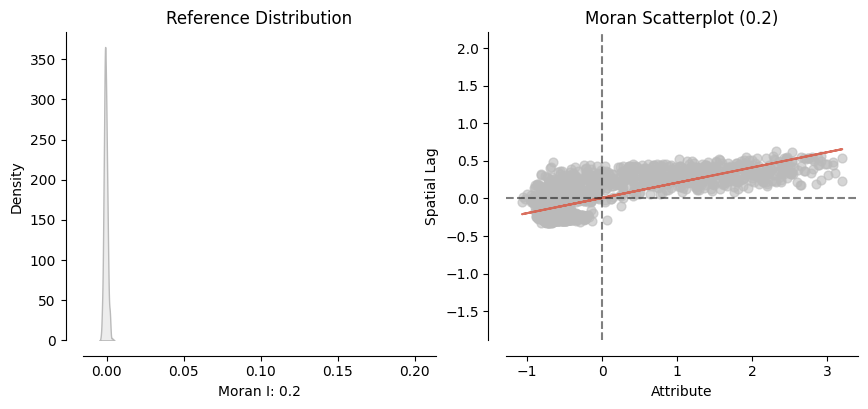

In [3]:
import geopandas as gpd
import requests
from libpysal.weights import DistanceBand

# Create a DistanceBand weights matrix
w_dist20km = DistanceBand.from_dataframe(gdf_restored,20_000, binary=False)

### First major plot
import esda
from splot.esda import plot_moran

mi = esda.Moran(gdf_restored['slope_mean'], w_dist20km)
plot_moran(mi);

(<Figure size 640x480 with 1 Axes>, <Axes: >)

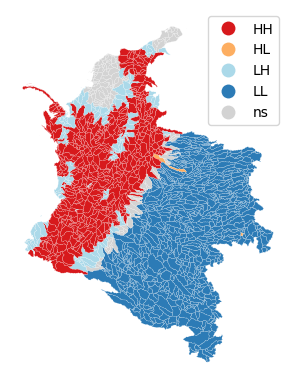

In [4]:
## Second major plot 
from splot.esda import lisa_cluster

lisa = esda.Moran_Local(gdf_restored["slope_mean"], w_dist20km)
lisa_cluster(lisa, gdf_restored)

In [5]:
q_labels = ['Q1', 'Q2', 'Q3', 'Q4']
labels = [q_labels[i - 1] for i in lisa.q]
gdf_restored["regime"] = labels  # Add this line

In [6]:
lisa.q

array([2, 1, 2, ..., 1, 1, 1], shape=(1700,))

In [7]:
## To R Studio

to_R = gdf_restored.rename(columns = { 'Historical_CWD_19852005' :'H_CWD',
                                      'Historical_RX5day_19852005' :'H_RX5day',
                                      'Historical_R95p_19852005':'H_R95p',
                                         'landslide_count':'lands_rec'
                                     }).copy()

# Your historical training variables
climate_vars = [
                'SUB_AREA',
                'H_CWD', 
                'H_RX5day',
                'H_R95p',
                'elev_mean',
                'slope_mean', 
                'PGA',
                'hypsometri',
                'y_log',
                'lands_rec',
                'regime',
                'geometry'
               ]

to_R.loc[: , climate_vars].to_file(r'C:\Users\Usuario\Documents\AI\Semestre 1\GeoSpatial\GEE_Landslide_Pipelines\R_computation\watershed.shp')

In [8]:
to_R['SUB_AREA'].isna().sum()

np.int64(0)

## 1.2 Intercepto variable (Efectos fijos espaciales)

Mientras asumimos que nuestra variable de proximidad podría representar un premium difícil de medir que las personas pagan cuando están cerca de una zona recreativa. Sin embargo, no todos los vecindarios son iguales; algunos vecindarios pueden ser más lucrativos que otros, independientemente de su proximidad a Balboa Park. Cuando este es el caso, necesitamos alguna forma de tener en cuenta el hecho de que cada vecindario puede experimentar estos tipos de efectos gestalt, únicos. Una forma de hacerlo es capturando la heterogeneidad espacial. En su forma más básica, la heterogeneidad espacial significa que partes del modelo pueden cambiar en diferentes lugares. Por ejemplo, los cambios en la intercepción, 
, pueden reflejar el hecho de que diferentes áreas tienen exposiciones basales diferentes a un proceso dado. Los cambios en los términos de pendiente, 
, pueden indicar algún tipo de factor mediador geográfico, como cuando una política gubernamental no se aplica de manera consistente en todas las jurisdicciones. Finalmente, los cambios en la varianza de los residuos, comúnmente denotada como 
, pueden introducir heterocedasticidad espacial.

Para ilustrar los efectos fijos espaciales, consideremos el ejemplo del precio de las casas de la sección anterior para introducir una ilustración más general de “espacio como proxy”. Dado que solo estamos incluyendo dos variables explicativas en el modelo, es probable que estemos omitiendo algunos factores importantes que juegan un papel en la determinación del precio al que se vende una casa. Algunos de ellos, sin embargo, es probable que varíen sistemáticamente en el espacio (por ejemplo, diferentes características del vecindario). Si ese es el caso, podemos controlar esos factores no observados utilizando variables dummy tradicionales pero basando su creación en una regla espacial. Por ejemplo, incluyamos una variable binaria para cada vecindario, indicando si una casa dada se encuentra dentro de dicho área (1) o no (0). Matemáticamente, ahora estamos ajustando la siguiente ecuación:


El enfoque anterior muestra cómo los Efectos Fijos Espaciales (FE) son un caso particular de una regresión lineal con una variable categórica. La pertenencia al vecindario se modela utilizando variables ficticias binarias. Gracias a la gramática de fórmulas utilizada en statsmodels, podemos expresar el modelo de manera abstracta, y Python lo analiza, creando apropiadamente variables binarias según sea necesario.

El segundo enfoque aprovecha la funcionalidad de Regímenes de PySAL, que permite al usuario especificar qué variables se estiman por separado para cada “régimen”. Sin embargo, en este caso, en lugar de describir el modelo en una fórmula, necesitamos pasar cada elemento del modelo como argumentos separados.

In [9]:
import statsmodels.formula.api as sm
import pandas as pd


# Spatial Fixed Effects model with terrain regimes
# Note: -1 removes the global intercept (like in the professor's example)
formula = "y_log ~ Historical_CWD_19852005 + Historical_RX5day_19852005 + Historical_R95p_19852005 + elev_mean+slope_mean+PGA + hypsometri + regime-1"

# Fit the model
## m_terrain_fe = sm.ols(  formula, data=gdf_restored).fit()
## print(m_terrain_fe.summary())

In [10]:
# Fit the model
m_terrain_fe = sm.ols(  formula, data=gdf_restored).fit()
print(m_terrain_fe.summary())

                            OLS Regression Results                            
Dep. Variable:                  y_log   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     22.13
Date:                Mon, 21 Jul 2025   Prob (F-statistic):           2.84e-39
Time:                        15:36:28   Log-Likelihood:                 2422.8
No. Observations:                1700   AIC:                            -4824.
Df Residuals:                    1689   BIC:                            -4764.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
regime[Q1]          

## 1.3 Intercepto y coeficientes variables

En el núcleo de la estimación de efectos fijos espaciales está la idea de que, en lugar de asumir que la variable dependiente se comporta uniformemente en el espacio, existen efectos sistemáticos que siguen un patrón geográfico y afectan su comportamiento. En otras palabras, los efectos fijos espaciales introducen econometricamente la noción de heterogeneidad espacial. Lo hacen en la forma más simple posible: al permitir que el término constante varíe geográficamente. Los demás elementos de la regresión permanecen sin cambios y, por lo tanto, se aplican uniformemente en todo el espacio. La idea de los regímenes espaciales (RE) es generalizar el enfoque de los efectos fijos espaciales para permitir que no solo el término constante varíe, sino también cualquier otra variable explicativa. Esto implica que la ecuación que estaremos estimando es:

 
donde no solo permitimos que el término constante varíe por región (
), sino también cada otro parámetro (
).

Para ilustrar este enfoque, usaremos el “diferenciador espacial” de si una casa está en un vecindario costero o no (coastal_neig) para definir los regímenes. La razón detrás de esta elección es que alquilar una casa cerca del océano podría ser un factor lo suficientemente fuerte como para que las personas estén dispuestas a pagar a diferentes tasas por cada una de las características de la casa.

Para implementar esto en Python, usamos la clase OLS_Regimes en PySAL, que hace la mayor parte del trabajo pesado por nosotros:

In [11]:
import pysal
from pysal.model import spreg
import numpy as np

# Prepare your data for PySAL
y = gdf_restored[['y_log']].values  # Target variable (log landslide density)
X = gdf_restored[climate_vars]  #.values  # Predictor variables

# Regime variable (your LISA terrain regimes)
regimes = gdf_restored['regime'].tolist()  # Q1, Q2, Q3, Q4

# Fit the spatial regimes model
m_terrain_regimes = spreg.OLS_Regimes(
    y=y,                          # log(landslide_density)
    x=X,                          # Climate + terrain variables  
    regimes=regimes,              # Q1, Q2, Q3, Q4 terrain regimes
    constant_regi='many',         # Separate intercept for each regime
    regime_err_sep=False,         # Assume same error variance across regimes
    name_y='log_landslide_density',
    name_x=climate_vars
)

print(m_terrain_regimes.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :log_landslide_density                Number of Observations:        1700
Mean dependent var  :      0.0139                Number of Variables   :          32
S.D. dependent var  :      0.0619                Degrees of Freedom    :        1668
R-squared           :      0.1338
Adjusted R-squared  :      0.1177
Sum squared residual:     5.63851                F-statistic           :      8.3107
Sigma-square        :       0.003                Prob(F-statistic)     :   1.787e-34
S.E. of regression  :       0.058                Log likelihood        :    2440.254
Sigma-square ML     :       0.003                Akaike info criterion :   -4816.507
S.E of regression ML:      0.0576                Schwarz criterion     :   -4642.479

-------------------------------

## 1.4 Modelos jerarquicos con R

A continuación se presenta el ajuste a un modelo de regresión logística estándar, evalúa su ajuste a través de pseudo-R cuadrados, obtiene las probabilidades predichas para cada observación y extrae un resumen limpio de los coeficientes del modelo en un data frame.


El modelo m2 es un modelo multinivel o modelo jerárquico que reconoce la estructura anidada de los datos, donde las observaciones individuales (subcuencas) están agrupadas dentro de unidades más grandes (cuencas). Los coeficientes de los efectos fijos (elev_mean_std, rel_mean_std, area_std, rainfallAnnual_mean_std) representan el efecto promedio de cada uno de estos predictores sobre la probabilidad de un movimiento en masa a través de todas las cuencas. Por ejemplo, el coeficiente de elev_mean_std te diría cómo cambia, en promedio, la probabilidad de un movimiento en masa por cada unidad de aumento en la elevación media estandarizada, manteniendo las otras variables constantes. Por otro lado, los efectos aleatorios permiten que la relación entre los predictores y la probabilidad de un movimiento en masa varíe entre las diferentes cuencas. El intercepto aleatorio para cada cuenca indica que algunas cuencas pueden tener una probabilidad base de movimientos en masa inherentemente mayor o menor que el promedio general, incluso después de tener en cuenta las variables predictoras. Esto podría deberse a factores específicos de cada cuenca que no se han medido directamente. Las pendientes aleatorias indican que el impacto de cada predictor (elevación, relieve, área, precipitación) sobre la probabilidad de un movimiento en masa puede ser diferente en cada cuenca. Por ejemplo, la elevación podría ser un factor más importante en algunas cuencas que en otras, o la relación entre la precipitación y los movimientos en masa podría variar. Esto podría reflejar diferencias en la geología, el tipo de suelo, la vegetación u otras características específicas de cada cuenca.

# 3. Regresión Ponderada Geográficamente (GWR)

Los Modelos de Regresión Espacial Ponderados (GWR, por sus siglas en inglés) constituyen una herramienta estadística avanzada desarrollada para analizar la heterogeneidad espacial de relaciones entre una variable respuesta y un conjunto de variables predictoras en un contexto geográfico (Brunsdon 1996, Fotheringham 2000, Fotheringham 2009). A diferencia de los modelos de regresión tradicional, que asumen que la relación entre las variables es constante en todo el espacio de estudio, los modelos GWR permiten que los coeficientes varíen de manera local. Esto se logra ajustando un modelo de regresión independiente en cada ubicación geográfica, utilizando datos cercanos para ponderar las estimaciones (Brunsdon 1996). Esta metodología es particularmente valiosa para el análisis de susceptibilidad a movimientos en masa, ya que permite representar cómo las diferentes condiciones del terreno afectan la susceptibilidad de manera no uniforme a lo largo de un área.

In [1]:
# Load datbase
import numpy as np
import numpy as np
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tabulate import tabulate

In [2]:
from load_dataset import gdf_restored

gdf_restored.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [3]:
gdf_restored.to_crs('EPSG:3857',inplace = True)

In [4]:
gdf_restored.head()

,HYBAS_ID,SUB_AREA,elev_mean,slope_mean,slope_p95,Historical_TP_mean_1985-2005,Historical_TP_median_1985-2005,Historical_TP_max_1985-2005,Historical_TP_p95_1985-2005,Historical_TP_min_1985-2005,...,SSP5 8.5_R95p_2020-2040,SSP5 8.5_R95p_2040-2060,SSP5 8.5_R95p_2060-2080,SSP5 8.5_R95p_2080-2100,PGA,suceptibility,hypsometri,landslide_count,landslide_density_km2,geometry
0,6080078040,346.9,42.340542,4.018225,17.889779,2404.761230,2428.441895,2910.226807,2820.092285,1925.344238,...,537.603149,554.961548,577.209412,615.566711,0.296658,1.487805,0.084118,2.0,0.005765,"POLYGON ((-8591617.268 886541.537, -8591463.87..."
1,6080078010,476.8,217.260793,9.887934,28.253847,2286.554443,2310.492188,2761.467773,2673.521973,1834.826172,...,508.305176,523.932190,545.238464,580.546631,0.316517,2.656646,0.143024,2.0,0.004195,"POLYGON ((-8598068.78 907858.497, -8597575.374..."
2,6080081280,442.1,71.756217,5.545883,17.810074,3264.778320,3312.593018,3909.392578,3782.051758,2658.418945,...,738.260132,763.765747,806.980835,859.036743,0.391662,1.899497,0.159063,0.0,0.000000,"POLYGON ((-8604140.557 867078.473, -8603367.69..."
3,6080081290,448.4,5.688645,2.044135,4.663393,3130.611816,3164.358887,3787.472412,3670.357178,2516.664795,...,709.090942,735.118896,769.690979,820.508850,0.365224,1.136513,0.068117,1.0,0.002230,"POLYGON ((-8581868.265 862176.15, -8581404.638..."
4,6080084300,847.4,131.561166,7.976072,20.737652,3264.778320,3312.593018,3909.392578,3782.051758,2658.418945,...,738.260132,763.765747,806.980835,859.036743,0.453975,2.301162,0.125951,1.0,0.001180,"POLYGON ((-8625868.811 845712.519, -8625829.59..."


In [5]:
import numpy as np
import pandas as pd
from mgwr.gwr import GWR, MGWR
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
from mgwr.gwr import GWR
from tqdm import TqdmExperimentalWarning
import warnings
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm


def restore_original_columns(gdf, mapping_path):
    """
    Restore original column names using the mapping dictionary.
    """
    # Load mapping
    with open(mapping_path, 'r') as f:
        mapping = json.load(f)
    
    # Create reverse mapping (encoded_name -> original_name)
    gdf_restored = gdf.copy()
    
    # Rename columns back to original names
    for encoded_name, original_name in mapping.items():
        if encoded_name in gdf_restored.columns:
            gdf_restored = gdf_restored.rename(columns={encoded_name: original_name})
    
    return gdf_restored

def load_shapefile_with_original_names(shapefile_path, mapping_path=None):
    """
    Load shapefile and restore original column names.
    """
    # Load shapefile
    gdf = gpd.read_file(shapefile_path)
    
    # Determine mapping path if not provided
    if mapping_path is None:
        mapping_path = str(Path(shapefile_path).with_suffix('.json'))
    
    # Restore original column names
    gdf_restored = restore_original_columns(gdf, mapping_path)
    
    return gdf_restored

def create_scenario_dictionary(gdf):
    """
    Create dictionary with climate scenarios organized by time period and SSP
    """
    scenarios = {}
    
    # Historical baseline (1985-2005)
    scenarios['Historical'] = {
                                    'CWD': 'Historical_CWD_1985-2005',
                                    'RX5day': 'Historical_RX5day_1985-2005', 
                                    'R95p': 'Historical_R95p_1985-2005'
                                }
    
    # SSP2 4.5 scenarios
    time_periods = ['2020-2040', '2040-2060', '2060-2080', '2080-2100']
    
    for period in time_periods:
        scenarios[f'SSP2_4.5_{period}'] = {
                                            'CWD': f'SSP2 4.5_CWD_{period}',
                                            'RX5day': f'SSP2 4.5_RX5day_{period}',
                                            'R95p': f'SSP2 4.5_R95p_{period}'
                                        }
    
    # SSP3 7.0 scenarios  
    for period in time_periods:
        scenarios[f'SSP3_7.0_{period}'] = {
                                            'CWD': f'SSP3 7.0_CWD_{period}',
                                            'RX5day': f'SSP3 7.0_RX5day_{period}',
                                            'R95p': f'SSP3 7.0_R95p_{period}'
                                        }
    
    # SSP5 8.5 scenarios
    for period in time_periods:
        scenarios[f'SSP5_8.5_{period}'] = {
                                            'CWD': f'SSP5 8.5_CWD_{period}',
                                            'RX5day': f'SSP5 8.5_RX5day_{period}',
                                            'R95p': f'SSP5 8.5_R95p_{period}'
                                        }
    
    return scenarios

def train_historical_gwr(gdf, scenario_dict):
    """
    Train GWR model using historical climate data - matches your exact workflow
    """
    print("Training GWR model with historical data...")

    # Load from file
    with open('gwr_selector.pkl', 'rb') as f:
        gwr_selector = pickle.load(f)
    
    # Prepare target variable (log-transformed landslide count)
    gdf['y_log'] = np.log(gdf['landslide_count'] + 1)
    g_y = gdf['y_log'].values.reshape(-1, 1)
    
    # Extract centroids (same as your approach)
    centroids = gdf.geometry.centroid
    X = centroids.x
    Y = centroids.y
    g_coords = list(zip(X, Y))
    
    # Prepare historical variables (exact same order as yours)
    variables = ['Historical_CWD_1985-2005', 
                 'Historical_RX5day_1985-2005',
                 'Historical_R95p_1985-2005',
                 'elev_mean',
                 'slope_mean',
                 'PGA',
                 'hypsometri']
    
    # Apply StandardScaler (same as your approach)
    scaler = StandardScaler()
    g_X_num = scaler.fit_transform(gdf[variables])
    
    # Train GWR model (exact same parameters as yours)
    ## model = GWR(g_coords, g_y, g_X_num, 100, kernel='gaussian', fixed=False).fit()

    # Fit the MGWR model using the selected bandwidths
    model = MGWR(g_coords, g_y, g_X_num, gwr_selector, kernel='bisquare', fixed=True).fit()
    model.summary()
    
    print("Historical GWR model trained successfully!")
    ## model.summary()
    
    return model, variables, scaler

def predict_scenario(model, gdf, scenario_dict, scenario_name, scaler):
    """
    Predict landslide count for a specific climate scenario
    SIMPLE: Same locations, just swap climate variables, keep same coefficients!
    """
    
    # For future scenarios: new climate + same static variables
    climate_vars = list(scenario_dict[scenario_name].values())  # New climate data
    static_vars = ['elev_mean', 'slope_mean', 'PGA', 'hypsometri']  # Same static data
    variables = climate_vars + static_vars
    
    # TRICK: Create temporary dataframe with historical column names for scaler
    temp_gdf = gdf[variables].copy()

    # Rename climate columns to match what scaler expects (historical names)
    historical_climate_names = ['Historical_CWD_1985-2005', 
                               'Historical_RX5day_1985-2005',
                               'Historical_R95p_1985-2005']
    
    # Create mapping from future scenario names to historical names
    rename_mapping = {}
    for i, future_name in enumerate(climate_vars):
        rename_mapping[future_name] = historical_climate_names[i]
    
    # Rename columns temporarily
    temp_gdf = temp_gdf.rename(columns=rename_mapping)
    
    # Now scaler will be happy because it sees the same column names as training
    expected_column_order = ['Historical_CWD_1985-2005', 
                            'Historical_RX5day_1985-2005',
                            'Historical_R95p_1985-2005',
                            'elev_mean',
                            'slope_mean',
                            'PGA',
                            'hypsometri']
    
    # Scale the data using the fitted scaler
    X_scenario = scaler.transform(temp_gdf[expected_column_order])
    
    # Add intercept column (GWR expects intercept as first column)
    X_scenario_with_intercept = np.column_stack([np.ones(X_scenario.shape[0]), X_scenario])
    
    # Use the SAME coefficients from the trained model (same locations!)
    # No distance calculations needed - just apply learned coefficients to new climate data
    predictions = np.sum(model.params * X_scenario_with_intercept, axis=1)
    
    return predictions

def run_climate_scenario_analysis(gdf):
    """
    Complete climate scenario analysis workflow - matches your exact training approach
    """
    print("="*60)
    print("CLIMATE SCENARIO LANDSLIDE ANALYSIS")
    print("="*60)
    
    # Step 1: Create scenario dictionary
    scenarios = create_scenario_dictionary(gdf)

    
    print(f"Created {len(scenarios)} climate scenarios")
    
    # Step 2: Train historical model (using your exact workflow)
    model, variables, scaler = train_historical_gwr(gdf, scenarios)
    
    # Step 3: Store all predictions
    predictions_dict = {}
    predictions_dict['Historical'] = model.predy.flatten()  # Historical predictions from training
    
    # Step 4: Predict for all future scenarios
    print("\\nPredicting for future scenarios...")
    
    for scenario_name in scenarios.keys():
        if scenario_name != 'Historical':
            print(f"  Predicting {scenario_name}...")
            pred = predict_scenario(model, gdf, scenarios, scenario_name, scaler)
            predictions_dict[scenario_name] = pred
            
    return predictions_dict,model

def plot_scenario_comparison(gdf, scenarios_to_plot=['SSP2_4.5_2080-2100', 'SSP5_8.5_2080-2100'], save_path=None):
    """
    Plot comparison of different climate scenarios - landslide count predictions
    """
    # Transform to WGS84 for plotting
    gdf_plot = gdf.to_crs(epsg=4326)
    
    n_scenarios = len(scenarios_to_plot) + 1  # +1 for historical
    fig, axes = plt.subplots(1, n_scenarios, figsize=(6*n_scenarios, 6))
    
    if n_scenarios == 1:
        axes = [axes]
    
    # Plot historical
    ax = axes[0]
    gdf_plot.plot(column='pred_count_Historical', ax=ax, cmap='Reds', legend=True)
    ax.set_title('Historical\\n(1985-2005)', fontsize=12, fontweight='bold')
    scalebar = ScaleBar(111319.49, "m", location='lower right',
                       scale_loc='top', length_fraction=0.25,
                       font_properties={"size": 10}, rotation='horizontal-only')
    ax.add_artist(scalebar)
    
    # Plot future scenarios
    for i, scenario in enumerate(scenarios_to_plot, 1):
        ax = axes[i]
        gdf_plot.plot(column=f'pred_count_{scenario}', ax=ax, cmap='Reds', legend=True)
        ax.set_title(f'{scenario.replace("_", " ")}', fontsize=12, fontweight='bold')
        scalebar = ScaleBar(111319.49, "m", location='lower right',
                           scale_loc='top', length_fraction=0.25,
                           font_properties={"size": 10}, rotation='horizontal-only')
        ax.add_artist(scalebar)
    
    plt.suptitle('Predicción del Conteo de Deslizamientos por Escenario Climático', fontsize=14, y=1.02)
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    plt.show()

# Usage example:
## gdf_results, predictions, model, scenarios, scaler = run_climate_scenario_analysis(gdf)
## plot_scenario_comparison(gdf_results,save_path= r"C:\Users\Usuario\Documents\AI\Semestre 1\GeoSpatial\Graficas\Entrega 2\Comparasion_escenarios_BEST_MODEL.png")

predictions_dict,model = run_climate_scenario_analysis(gdf_restored)

print("Climate scenario analysis functions ready!")
print("\\nTo run the analysis:")
print("gdf_results, predictions, model, scenarios, scaler = run_climate_scenario_analysis(gdf)")
print("plot_scenario_comparison(gdf_results)")
print("plot_change_maps(gdf_results)")

CLIMATE SCENARIO LANDSLIDE ANALYSIS
Created 13 climate scenarios
Training GWR model with historical data...


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Model type                                                         Gaussian
Number of observations:                                                1700
Number of covariates:                                                     8

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1568.450
Log-likelihood:                                                   -2343.736
AIC:                                                               4703.472
AICc:                                                              4705.579
BIC:                                                             -11017.295
R2:                                                                   0.518
Adj. R2:                                                              0.516

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [6]:
predictions_dict

{'Historical': array([ 0.87176597,  0.73801451,  0.76408775, ...,  0.09771089,
         2.27469922, -0.32944642], shape=(1700,)),
 'SSP2_4.5_2020-2040': array([ 0.7982553 ,  0.69743094,  0.79950069, ...,  0.35283813,
         2.41393849, -0.43251933], shape=(1700,)),
 'SSP2_4.5_2040-2060': array([ 0.89690815,  0.7798932 ,  0.90958976, ...,  0.18022494,
         2.30074183, -0.51735789], shape=(1700,)),
 'SSP2_4.5_2060-2080': array([ 0.87953584,  0.76606033,  0.83254915, ...,  0.46516127,
         2.43331253, -0.64495309], shape=(1700,)),
 'SSP2_4.5_2080-2100': array([ 0.95462368,  0.82435342,  0.88597624, ...,  0.34578547,
         2.33215023, -0.75273238], shape=(1700,)),
 'SSP3_7.0_2020-2040': array([ 0.87532674,  0.76742122,  0.89468719, ...,  0.08014027,
         2.29810019, -0.45725722], shape=(1700,)),
 'SSP3_7.0_2040-2060': array([ 0.89651921,  0.786712  ,  0.81347688, ...,  0.47755225,
         2.36187074, -0.60823713], shape=(1700,)),
 'SSP3_7.0_2060-2080': array([ 0.88388115,

In [88]:
import matplotlib.pyplot as plt
import numpy as np

# Transform to WGS84 for plotting
gdf_plot = gdf_restored.to_crs(epsg=4326).copy()
gdf_plot = gdf_plot.loc[: , ['HYBAS_ID','geometry']]

# Calcular diferencias contra histórico
historical = predictions_dict['Historical']
historical_original = np.exp(historical) - 1
differences = {}
# Diferencia absoluta en conteos
gdf_plot["Historical_1985-2005"] = historical_original

# Calcular diferencias en escala original
for scenario, values in predictions_dict.items():
    if scenario != 'Historical':
        # Revertir transformación log(count + 1)
        
        scenario_original = np.exp(values) - 1
        
        # Diferencia absoluta en conteos
        gdf_plot[f"{scenario}_diff"] = scenario_original - historical_original

# Melt all columns except 'HYBAS_ID' and 'geometry'
melted = pd.melt(
    gdf_plot,
    id_vars=['HYBAS_ID', 'geometry'],
    var_name='cmpi6_rainfall',
    value_name='exp(log)-1'
)

melted[['Escenario' ,'Horizonte']] = melted.cmpi6_rainfall.str.extract(r"(?P<Escenario>.+)?_(?P<Horizonte>\d{4}-\d{4})")

melted.drop(columns = ['cmpi6_rainfall','HYBAS_ID' , 'geometry'] ,inplace = True)

In [90]:
melted.groupby(['Escenario' , 'Horizonte']).agg({'exp(log)-1': ('mean','max')}).to_clipboard()

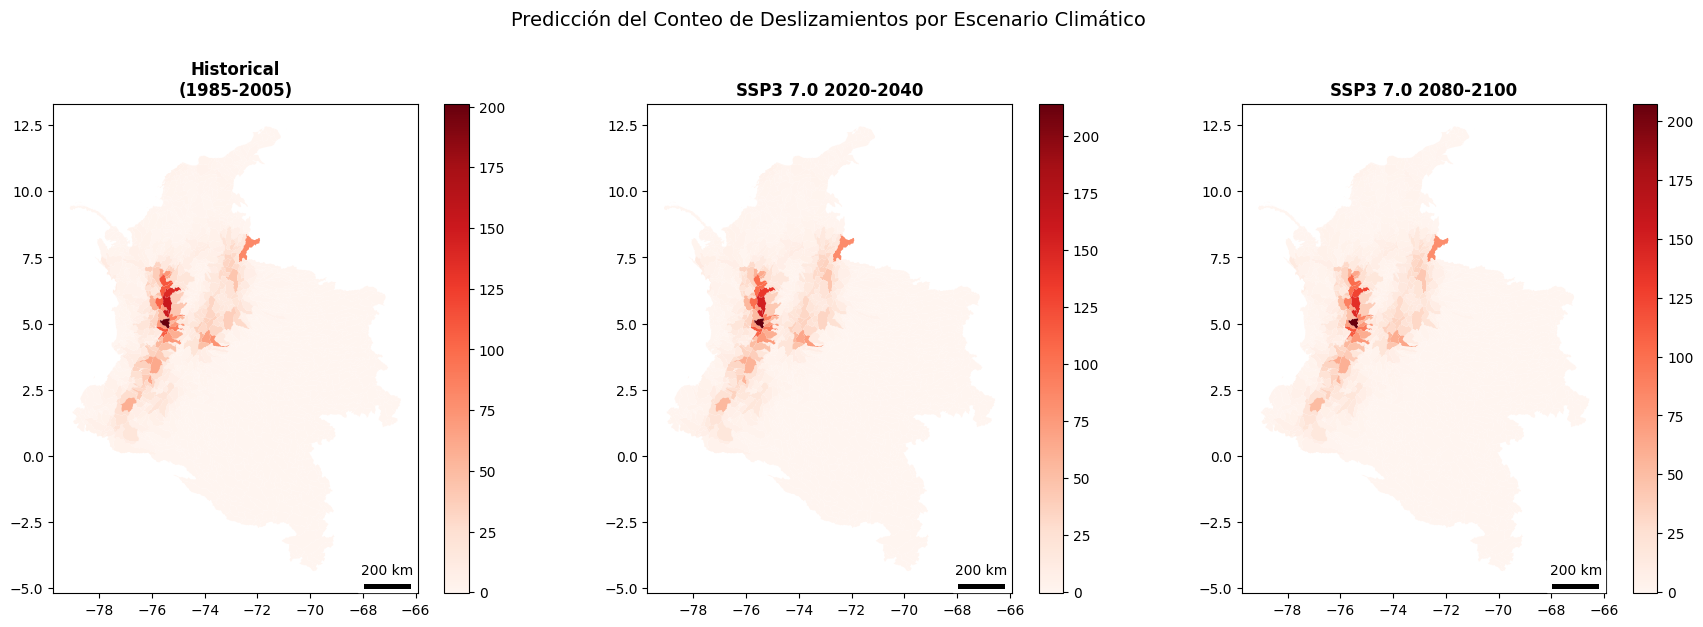

In [82]:
scenarios_to_plot = ['SSP3_7.0_2020-2040', 'SSP3_7.0_2080-2100']

n_scenarios = len(scenarios_to_plot) + 1  # +1 for historical
fig, axes = plt.subplots(1, n_scenarios, figsize=(6*n_scenarios, 6))

if n_scenarios == 1:
    axes = [axes]

# Plot historical
ax = axes[0]
gdf_plot.plot(column='Historical_1985-2005', ax=ax, cmap='Reds', legend=True)
ax.set_title('Historical\n(1985-2005)', fontsize=12, fontweight='bold')
scalebar = ScaleBar(111319.49, "m", location='lower right',
                   scale_loc='top', length_fraction=0.25,
                   font_properties={"size": 10}, rotation='horizontal-only')
ax.add_artist(scalebar)

# Plot future scenarios
for i, scenario in enumerate(scenarios_to_plot, 1):
    ax = axes[i]
    gdf_plot.plot(column=f"{scenario}", ax=ax, cmap='Reds', legend=True)
    ax.set_title(f'{scenario.replace("_", " ")}', fontsize=12, fontweight='bold')
    scalebar = ScaleBar(111319.49, "m", location='lower right',
                       scale_loc='top', length_fraction=0.25,
                       font_properties={"size": 10}, rotation='horizontal-only')
    ax.add_artist(scalebar)

plt.suptitle('Predicción del Conteo de Deslizamientos por Escenario Climático', fontsize=14, y=1.02)
plt.tight_layout()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7820\4246783943.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(diff_values, labels=scenario_names, patch_artist=True)


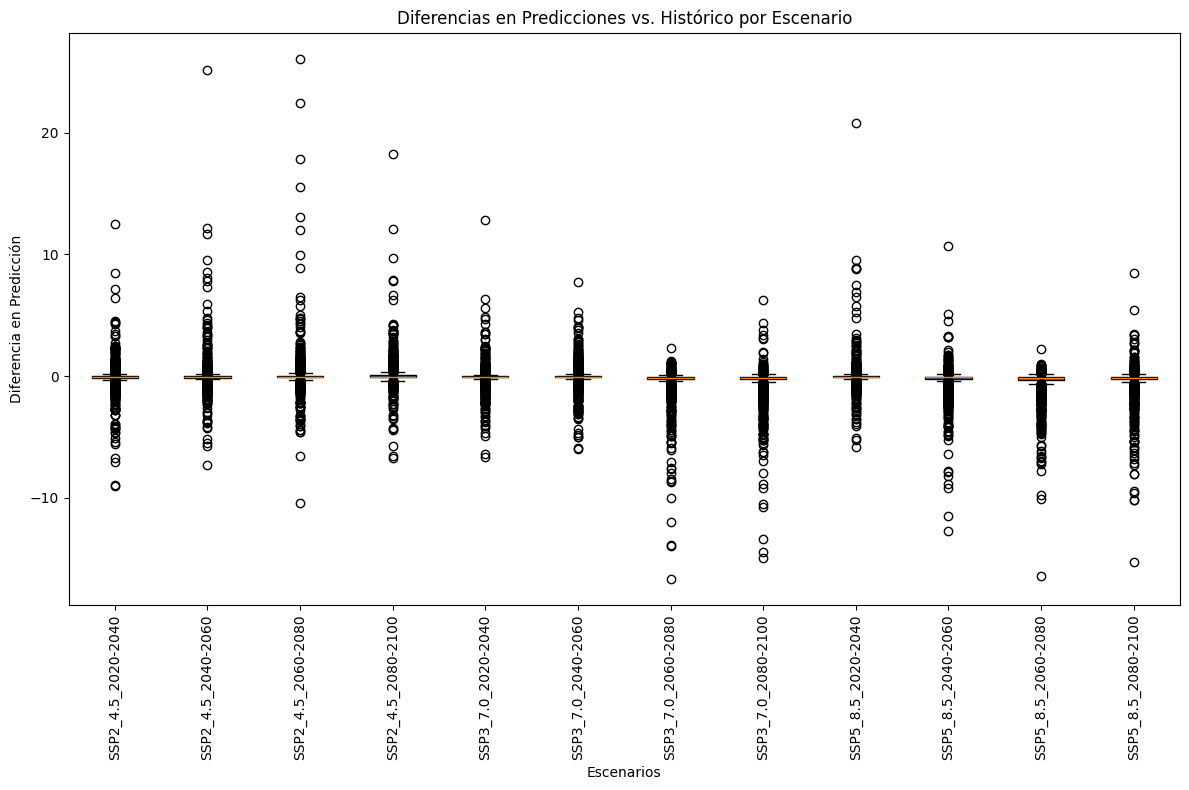

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Calcular diferencias contra histórico
historical = predictions_dict['Historical']
differences = {}

# Calcular diferencias en escala original
for scenario, values in predictions_dict.items():
    if scenario != 'Historical':
        # Revertir transformación log(count + 1)
        historical_original = np.exp(historical) - 1
        scenario_original = np.exp(values) - 1
        
        # Diferencia absoluta en conteos
        differences[scenario] = scenario_original - historical_original

# Plot boxplots de diferencias
fig, ax = plt.subplots(figsize=(12, 8))
scenario_names = list(differences.keys())
diff_values = [differences[scenario] for scenario in scenario_names]

bp = ax.boxplot(diff_values, labels=scenario_names, patch_artist=True)
ax.set_title('Diferencias en Predicciones vs. Histórico por Escenario')
ax.set_ylabel('Diferencia en Predicción')
ax.set_xlabel('Escenarios')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()